# Creating random training data polygons

Using Collect Earth Online (CEO), these randomly scattered polygons will be classified as crop, non-crop, or mixed and form the knowledge base for the machine learning classifier.

Stratifying points using the GFSAD cropland extent map (30m resolution).
    
    import os
    os.chdir('data/GFSAD/')
    gdalwarp -tr 0.0005389891704717132 0.0005389891704717132  -r mode GFSAD_mosaic.tif GFSAD_mosaic_60m.tif

### Load modules

In [1]:
import geopandas as gpd
from datacube.utils.cog import write_cog
import xarray as xr
import numpy as np
import pandas as pd
import datacube
from affine import Affine
from datacube.utils.geometry import assign_crs

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize
from deafrica_dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore")

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37343 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis Parameters

In [3]:
# asap_crop_mask = 'data/asap_mask_crop_v03.tif'
crop_mask_shp = 'data/GFSAD/GFSAD_mosaic_60m.tif'

#AEZ to mask crop mask
aez = 'data/AEZs/Eastern.shp'

#location and file name to store shapefiles.
results = 'data/training_validation/collect_earth/Eastern_TD'

#total number of sample points
n_sample = 2000

#nuof classes to sample
n_class= 2

### Open datasets

In [4]:
#open AEZ shapefile
aez = gpd.read_file(aez)

#find bouding box
xmin,ymin,xmax,ymax = aez.bounds.values[0][0], aez.bounds.values[0][1], aez.bounds.values[0][2], aez.bounds.values[0][3]

In [5]:
#open GFSAD cropmask at bounding coords of AEZ
da = xr.open_rasterio(crop_mask_shp).squeeze().sel(x=slice(xmin,xmax),
                                                  y=slice(ymax,ymin)).chunk({'x':3000, 'y':3000})
attrs = da.attrs

#rename x and y because for some reason the geobox params are different than xarray coords
da = da.rename({'x':'longitude', 'y':'latitude'})


### Mask by AEZ

In [7]:
aez_raster = xr_rasterize(aez, da)

Rasterizing to match xarray.DataArray dimensions (49437, 35491)


In [8]:
da = da.where(aez_raster).astype(np.int8)
da = da.to_dataset(name='GFSAD')
da.attrs = attrs

In [9]:
da = da.compute()

In [ ]:
# write_cog(crop_mask,
#           'data/GFSAD/' + name + '_GFSAD.tif')

# from datacube.helpers import write_geotiff
# write_geotiff('data/GFSAD/' + name + '_GFSAD.tif',
#                 crop_mask.to_dataset(name='Southern_GFSAD'),
#              )

### Generate random points

2000 random points: 50% (1000) in 2, 25% (500) in 1, 25% (500) in 0

In [18]:
#rename back to x & y
da = da.rename({'longitude':'x', 'latitude':'y'})

In [19]:
class_sizes =[]
for class_id in np.arange(1, n_class+1):
    print(class_id)
    class_sizes.append((da.GFSAD==class_id).sum().values)

class_sizes = np.array(class_sizes)
print(class_sizes)
print(class_sizes/class_sizes.sum())

1
2
[624827958 172001762]
[0.78414239 0.21585761]


In [20]:
n_sample_class = np.ceil(n_sample*1./ n_class).astype(int)
print(n_sample_class)

1100


In [21]:
label_picked = {}
for class_id in np.arange(1, n_class+1):
    if class_sizes[class_id-1]> 1e9:
        # slightly over sample
        n_sample_over = np.ceil(n_sample_class*len(da.x)*len(da.y)/class_sizes[class_id-1]).astype(int)
        random_x = np.random.choice(np.arange(len(da.x)), n_sample_over, replace=False)
        random_y = np.random.choice(np.arange(len(da.y)), n_sample_over, replace=False)
        match = da.GFSAD.values[random_y, random_x] == class_id
        random_y, random_x = random_y[match], random_x[match]
        if len(random_y) < n_sample_class:
            print("Not enough points are picked, try increase the number of random points")
            break
        else:
            pick = np.random.choice(np.arange(len(random_y)), n_sample_class, replace=False)
            y, x = random_y[pick], random_x[pick]
    else:
        index = np.argwhere(da.GFSAD.values.flatten() == class_id).squeeze()
        picked = np.random.choice(index, n_sample_class, replace=False)
        # convert back to x, y 
        y, x  = np.unravel_index(picked, da.GFSAD.values.shape)
    label_picked[class_id] = (y, x)
    np.savetxt(f'{results}_class_{class_id}.csv', 
               np.vstack((da.y[y].values, 
                          da.x[x].values)).transpose(),fmt='%d', delimiter=',')


In [22]:
for class_id in np.arange(1, n_class+1):
    y, x = label_picked[class_id]
    df = pd.DataFrame({'y': da.y[y].values, 'x':da.x[x].values})
    df['class']=class_id
    if class_id ==1: 
        dfs = df
    else: 
        dfs = dfs.append(df, ignore_index=True)

In [23]:
gdf_points = gpd.GeoDataFrame(
            dfs,
            crs=da.crs,
            geometry=gpd.points_from_xy(dfs.x, dfs.y)).reset_index()

gdf_points = gdf_points.drop(['x', 'y'],axis=1)

#add a PLOTID field to satisfy CEO
gdf_points['PLOTID'] = range(0,len(gdf_points))
gdf_points['SAMPLEID'] = range(0,len(gdf_points))


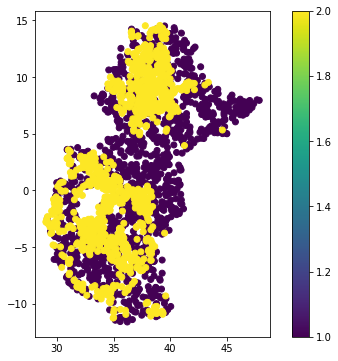

In [24]:
gdf_points.plot(figsize=(8,6), column='class', legend=True)

### Add subsample of points from GFSAD

This will serve as an internal validation dataset.  Append 100 samples from GFSAD per region, 50 crop & 50 non-crop, and shuffle them within the larger dataset.
We need a row identifying them so we can extract after the classification.

In [27]:
#open data
gfsad_shp = 'data/training_validation/GFSAD2015/cropland_prelim_validation_GFSAD.shp'
gfsad_gdf = gpd.read_file(gfsad_shp)

#clip to AEZ
gfsad_gdf = gpd.overlay(gfsad_gdf,aez,how='intersection')

In [37]:
#sample 50 points from each class
crops = gfsad_gdf[gfsad_gdf['class']==1].sample(n=50)
noncrops = gfsad_gdf[gfsad_gdf['class']==0].sample(n=50)

In [42]:
# crops

### Shuffle rows so classes aren't sequential in CEO

In [ ]:
gdf_points = gdf_points.sample(frac=1).reset_index(drop=True)

### Convert points to square polygons

In [ ]:
gdf_points = gpd.read_file(results + '_points.shp')


In [ ]:
#set radius (in metres) around points
radius = 40

#convert to equal area to set polygon size in metres
gdf_poly = gdf_points.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
gdf_poly['geometry'] = gdf_poly['geometry'].buffer(radius).envelope

#Convert back to lat/lon
gdf_poly = gdf_poly.to_crs('EPSG:4326')

In [ ]:
#export to file
gdf_poly.to_file(results + '_polys.shp')

gdf_points.to_file(results + '_points.shp')

In [ ]:
# def random_sampling(da,
#                     n,
#                     sampling='stratified_random',
#                     manual_class_ratios=None,
#                     out_fname=None
#                    ):
    
#     """
#     Creates randomly sampled points for post-classification
#     accuracy assessment.
    
#     Params:
#     -------
#     da: xarray.DataArray
#         A classified 2-dimensional xarray.DataArray
#     n: int
#         Total number of points to sample. Ignored if providing
#         a dictionary of {class:numofpoints} to 'manual_class_ratios'
#     sampling: str
#         'stratified_random' = Create points that are randomly 
#         distributed within each class, where each class has a
#         number of points proportional to its relative area. 
#         'equal_stratified_random' = Create points that are randomly
#         distributed within each class, where each class has the
#         same number of points.
#         'random' = Create points that are randomly distributed
#         throughout the image.
#         'manual' = user definined, each class is allocated a 
#         specified number of points, supply a manual_class_ratio 
#         dictionary mapping number of points to each class
#     manual_class_ratios: dict
#         If setting sampling to 'manual', the provide a dictionary
#         of type {'class': numofpoints} mapping the number of points
#         to generate for each class.
#     out_fname: str
#         If providing a filepath name, e.g 'sample_points.shp', the
#         function will export a shapefile/geojson of the sampling
#         points to file.
    
#     Output
#     ------
#     GeoPandas.Dataframe
    
#     """
    
#     if sampling not in ['stratified_random', 'equal_stratified_random', 'random', 'manual']:
#         raise ValueError("Sampling strategy must be one of 'stratified_random', "+
#                              "'equal_stratified_random', 'random', or 'manual'") 
    
#     #open the dataset as a pandas dataframe
#     da = da.squeeze()
#     df = da.to_dataframe(name='class')
    
#     #list to store points
#     samples = []
    
#     if sampling == 'stratified_random':
#         #determine class ratios in image
#         class_ratio = pd.DataFrame({'proportion': df['class'].value_counts(normalize=True),
#                             'class':np.unique(df['class'])
#                                  })
        
#         for _class in class_ratio['class']:
#             #use relative proportions of classes to sample df
#             no_of_points = n * class_ratio[class_ratio['class']==_class]['proportion'].values[0]
#             #random sample each class
#             print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
#             sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
#             samples.append(sample_loc)

#     if sampling == 'equal_stratified_random':
#         classes = np.unique(df['class'])
        
#         for _class in classes:
#             #use relative proportions of classes to sample df
#             no_of_points = n / len(classes)
#             #random sample each classes
#             try:
#                 sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
#                 print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
#                 samples.append(sample_loc)
            
#             except ValueError:
#                         print('Requested more sample points than population of pixels for class '+ str(_class)+', skipping')
#                         pass
    
#     if sampling == 'random':
#         no_of_points = n
#         #random sample entire df
#         print('Randomly sampling dataAraay at '+ str(round(no_of_points)) + ' coordinates')
#         sample_loc = df.dropna().sample(n=int(round(no_of_points)))
#         samples.append(sample_loc)
    
#     if sampling == 'manual':
#         if isinstance(manual_class_ratios, dict):
#             #check classes in dict match classes in data
#             classes = np.unique(df['class'])
#             dict_classes = list(manual_class_ratios.keys())
            
#             if set(dict_classes).issubset([str(i) for i in classes]):
#                 #mask for just those classes in the provided dictionary
#                 mask = np.isin(classes,
#                                np.array(dict_classes).astype(type(classes[0])))
#                 classes = classes[mask]               
#                 #run sampling
#                 for _class in classes:
#                     no_of_points = manual_class_ratios.get(str(_class))
#                     #random sample each class
#                     try:
#                         sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
#                         print('Class '+ str(_class)+ ': sampled at '+ str(round(no_of_points)) + ' coordinates')
#                         samples.append(sample_loc)
                        
#                     except ValueError:
#                         print('Requested more sample points than population of pixels for class '+ str(_class)+', skipping')
#                         pass

#             else:
#                 raise ValueError("Some or all of the classes in 'manual_class_ratio' dictionary do not" +
#                                  " match the classes in the supplied dataArray. "+
#                                 "DataArray classes: "+str(classes)+", Supplied dict classes: "+
#                                  str(list(manual_class_ratios.keys())))
            
#         else:
#             raise ValueError("Must supply a dictionary mapping {'class': numofpoints} if sampling" +
#                              " is set to 'manual'")
    
#     #join back into single datafame
#     all_samples = pd.concat([samples[i] for i in range(0,len(samples))])
        
#     #get pd.mulitindex coords as list 
#     y = [i[0] for i in list(all_samples.index)]
#     x = [i[1] for i in list(all_samples.index)]

#     #create geopandas dataframe
#     gdf = gpd.GeoDataFrame(
#         all_samples,
#         crs=da.crs,
#         geometry=gpd.points_from_xy(x,y)).reset_index()

#     gdf = gdf.drop(['x', 'y'],axis=1)
    
#     if out_fname is not None:
#         gdf.to_file(out_fname)
    
#     return gdf